In [1]:
!kaggle datasets download -d jehanbhathena/weather-dataset


  0%|          | 0.00/587M [00:00<?, ?B/s]
  0%|          | 1.00M/587M [00:00<05:40, 1.81MB/s]
  0%|          | 2.00M/587M [00:00<03:49, 2.67MB/s]
  1%|          | 3.00M/587M [00:01<03:15, 3.14MB/s]
  1%|          | 4.00M/587M [00:01<02:54, 3.49MB/s]
  1%|          | 5.00M/587M [00:01<03:02, 3.35MB/s]
  1%|          | 6.00M/587M [00:01<02:45, 3.69MB/s]
  1%|          | 7.00M/587M [00:02<02:30, 4.05MB/s]
  1%|▏         | 8.00M/587M [00:02<02:30, 4.04MB/s]
  2%|▏         | 9.00M/587M [00:02<02:21, 4.27MB/s]
  2%|▏         | 10.0M/587M [00:02<02:21, 4.27MB/s]
  2%|▏         | 11.0M/587M [00:03<02:17, 4.40MB/s]
  2%|▏         | 12.0M/587M [00:03<02:11, 4.60MB/s]
  2%|▏         | 13.0M/587M [00:03<02:15, 4.43MB/s]
  2%|▏         | 14.0M/587M [00:03<02:22, 4.23MB/s]
  3%|▎         | 15.0M/587M [00:04<02:16, 4.40MB/s]
  3%|▎         | 16.0M/587M [00:04<02:13, 4.50MB/s]
  3%|▎         | 17.0M/587M [00:04<02:10, 4.57MB/s]
  3%|▎         | 18.0M/587M [00:04<02:07, 4.66MB/s]
  3%|▎         | 19.

In [1]:
import zipfile
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
zip_file = "C:/Users/darre/Documents/GitHub/Weather-Recognition/weather-dataset.zip"
extract_dir = "C:/Users/darre/Documents/GitHub/Weather-Recognition"

# os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [4]:
data_dir = "C:/Users/darre/Documents/GitHub/Weather-Recognition/dataset"
new_data_dir = "C:/Users/darre/Documents/GitHub/Weather-Recognition/dataset_fix"

os.makedirs(new_data_dir, exist_ok=True)

# Create train and test folders inside the new dataset folder
train_folder = os.path.join(new_data_dir, "train")
test_folder = os.path.join(new_data_dir, "test")
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        # Split the class images into train and test sets
        images = [os.path.join(class_path, image_name) for image_name in os.listdir(class_path)]
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Create class folders inside train and test folders
        train_class_folder = os.path.join(train_folder, class_folder)
        test_class_folder = os.path.join(test_folder, class_folder)
        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(test_class_folder, exist_ok=True)

        # Move images to the appropriate class folders
        for image_path in train_images:
            shutil.copy(image_path, os.path.join(train_class_folder, os.path.basename(image_path)))
        for image_path in test_images:
            shutil.copy(image_path, os.path.join(test_class_folder, os.path.basename(image_path)))

In [2]:
seed_value = 13
tf.random.set_seed(seed_value)

In [27]:
target_size = (224, 224,)

# Load the pre-trained VGG16 model
base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(640, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(11, activation='relu')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 62720)             0         
                                                                 
 dense_49 (Dense)            (None, 640)               40141440  
                                                                 
 dense_50 (Dense)            (None, 512)               328192    
                                                                 
 dense_51 (Dense)            (None, 256)               131328    
                                                                 
 dense_52 (Dense)            (None, 128)               32896     
                                                      

In [28]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    directory="C:/Users/darre/Documents/GitHub/Weather-Recognition/dataset_fix/train",
    target_size=(224, 224,),
    batch_size=16,
    class_mode='categorical'
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    directory="C:/Users/darre/Documents/GitHub/Weather-Recognition/dataset_fix/test",
    target_size=(224, 224,),
    batch_size=16,
    class_mode='categorical'
)

Found 5484 images belonging to 11 classes.
Found 1378 images belonging to 11 classes.


In [30]:
base_epoch = 10
history = model.fit(train_generator, epochs=base_epoch, validation_data=val_generator,verbose=2)

Epoch 1/10
343/343 - 198s - loss: 4.9268 - accuracy: 0.2485 - val_loss: 2.1801 - val_accuracy: 0.3019 - 198s/epoch - 577ms/step
Epoch 2/10
343/343 - 204s - loss: 2.0122 - accuracy: 0.3609 - val_loss: 1.5038 - val_accuracy: 0.4274 - 204s/epoch - 594ms/step
Epoch 3/10
343/343 - 204s - loss: 1.6300 - accuracy: 0.4672 - val_loss: 1.4377 - val_accuracy: 0.5885 - 204s/epoch - 595ms/step
Epoch 4/10
343/343 - 204s - loss: 1.4425 - accuracy: 0.5678 - val_loss: 1.2850 - val_accuracy: 0.6560 - 204s/epoch - 594ms/step
Epoch 5/10
343/343 - 210s - loss: 1.2839 - accuracy: 0.6594 - val_loss: 1.2641 - val_accuracy: 0.7126 - 210s/epoch - 613ms/step
Epoch 6/10
343/343 - 202s - loss: 1.1465 - accuracy: 0.7319 - val_loss: 1.2728 - val_accuracy: 0.7525 - 202s/epoch - 590ms/step
Epoch 7/10
343/343 - 203s - loss: 1.0315 - accuracy: 0.7753 - val_loss: 1.1863 - val_accuracy: 0.7663 - 203s/epoch - 592ms/step
Epoch 8/10
343/343 - 206s - loss: 1.2478 - accuracy: 0.7181 - val_loss: 1.2044 - val_accuracy: 0.7467 - 

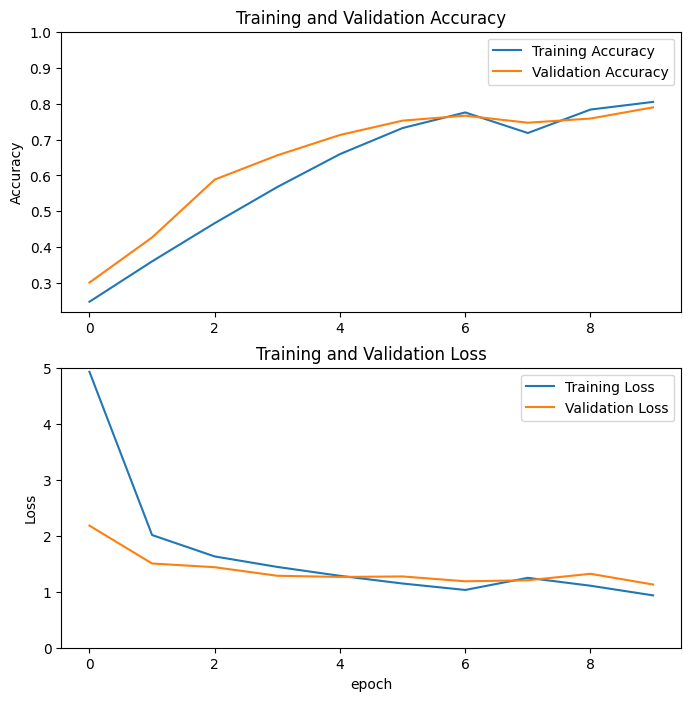

In [31]:
#Get training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Code to make the accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy') #Give labels
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right') #Location of the legends, make sure not to disturb your visualization)
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

#Code to make the loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
model.save('model_mobilenetv2.h5')

In [35]:
class_indices = train_generator.class_indices

# Print the class labels and their corresponding indices
for label, index in class_indices.items():
    print(f"Class: {label} - Index: {index}")

Class: dew - Index: 0
Class: fogsmog - Index: 1
Class: frost - Index: 2
Class: glaze - Index: 3
Class: hail - Index: 4
Class: lightning - Index: 5
Class: rain - Index: 6
Class: rainbow - Index: 7
Class: rime - Index: 8
Class: sandstorm - Index: 9
Class: snow - Index: 10
